# **Analysis of the Impact of Weather on NFL Games** - Data Science Tutorial

Alex Evans - CMSC320

**Introduction**

Data science is an extremely important tool for professional sports, especially in the National Football League where each game has an average of over 140 plays to analayze. While most statistics are gathered about players and performance, it is also useful to look at non-football factors that may impact games. As technology advances, many newer NFL stadiums include a roof in order to regulate the weather conditions inside the stadium. Since NFL games are played between the months of August and Februrary, weather is always a factor when playing outside.

While the NFL cannot regulate the use of domes for new stadiums, they do have the authority to choose where the super bowl is located. From this project, it will become evident whether or not weather impacts an NFL game, and if teams who are used to the cold weather perform better. If weather is indeed a factor, the NFL should choose super bowl locations wisely, and teams may want to carefully consider designs for a new stadium. To learn about this subject, we can look at how outcomes differ for home and away teams based on weather conditions.

This will also be useful for betting. In the state of Maryland, online sports gambling was just legalized. Betting lines are often based on point totals, so it will be useful to see how weather impacts point totals. While this project will not attempt to determine outcomes of games based on weather, the results of this project should determine whether or not that would be possible. We will mainly look at temperature and wind speeds throughout the project.

This project will utilize all elements of the data science pipeline - data curation, parsing, and management; exploratory data analysis; hypothesis testing
and machine learning to provide analysis; and then the curation of a message covering insights learned during the tutorial. This project will not only inform readers about the impact of weather on nfl games, but it will also detail the data science pipeline in depth in order to teach the reader specific techniques.

The dataset can be found here: https://github.com/shmilyface/nflsavant/blob/master/weather_20131231.csv

**Additional Information**
When evaluating probabilities and predicting outcomes of games, we base it on the average outcomes of prior games. These are not based on the skill of the team, since the prior outcomes will average out to being even matchups. Therefore, these predictions are more valid for balanced matchups between evenly-skilled teams.

In addition, there is mention of certain betting odds that may be unfamiliar to readers. Betting odds will be in the format of "Team -#" such as "Eagles -3.5." This means that someone is betting on the Eagles to win by at least 3.5 points. In addition, there is +/- on total score, meaning that someone is betting for the total score to be either above or below a certain value. For more information on this, a helpful link is below:
https://www.sportsbookreview.com/how-to-bet-on-sports/beginner/how-to-read-odds/#:~:text=If%20there's%20a%20positive%20sign,win%20if%20you%20bet%20%24100.&text=Now%20if%20there%20is%20a,bet%20%24250%20to%20win%20%24100.

**Note** - All values with respect to wind will be represented in Miles per Hour, and all values with respect to temperature or wind chill will be represented in Degrees Fahrenheit

# **Data Collection**

In this section, we import the libraries necessary for our project and import the data that we will use. Weather statistics are from the years 1960 through 2013

In [ ]:
# Before starting, many libraries must be imported for use in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression


In [ ]:
#Import the data from a local file
data = pd.read_csv("NFLweather.csv", sep=',')
data.head()

id  ...       date
0  196009230ram  ...  9/23/1960
1  196009240dal  ...  9/24/1960
2  196009250gnb  ...  9/25/1960
3  196009250sfo  ...  9/25/1960
4  196009250clt  ...  9/25/1960

[5 rows x 11 columns]

# **Data Processing**

Next, we must get this data into a machine-readable format. For example, we must take the "humidity" column that contains a string, and turn it into pure integer data. To do this, we apply a string function to the entire column. We also replace NaN values with 0 in wind_mph, and with 1000 in wind chill since we are taking the minimum of wind chill and temperature to find the wind_temp.

In [ ]:
#Take the % out of the humidity column using string operations
data['humidity'] = data.humidity.str.strip('%')
data['humidity'] = data['humidity'].fillna(0)
data['humidity'] = (data.humidity).astype(int)

#Add a "total score" column by combining home_score and away_score
data['total_score'] = data.home_score + data.away_score

#Since wind_chill is full of NaN values, we can make column for temperature with wind chill
data['wind_chill'] = data['wind_chill'].fillna(1000) 
data['wind_temp'] = data[['temperature', 'wind_chill']].min(axis=1)
data.drop(columns='wind_chill', inplace=True)

#Make a column for if the home team won, using 1 to represent yes/tie and 0 to represent no
data['home_win'] = data['home_score'].ge(data['away_score'])
data["home_win"] = data["home_win"].astype(int)

#Fill NaN values in wind_mph with 0
data['wind_mph'] = data['wind_mph'].fillna(0) 

#Make a column for year
data['year'] = pd.DatetimeIndex(data['date']).year

#Preview data
data.head()

id            home_team  home_score  ... wind_temp  home_win  year
0  196009230ram     Los Angeles Rams          21  ...      66.0         0  1960
1  196009240dal       Dallas Cowboys          28  ...      72.0         0  1960
2  196009250gnb    Green Bay Packers          14  ...      60.0         0  1960
3  196009250sfo  San Francisco 49ers          19  ...      72.0         0  1960
4  196009250clt      Baltimore Colts          20  ...      62.0         1  1960

[5 rows x 14 columns]

In [ ]:
#Gather stats for average values (temperature, temperature with wind chill, humidity, wind)

avg_temp = data['temperature'].mean()
avg_wctemp = data['wind_temp'].mean()
avg_humid = data['humidity'].mean()
avg_wind = data['wind_mph'].mean()
print('Average temperature (Fahrenheit) = ' + avg_temp.astype(str))
print('Average temperature w/ wind chill = ' + str(avg_wctemp))
print('Average humidity (%) = ' + avg_humid.astype(str))
print('Average wind speed (mph) = ' + str(avg_wind))

Average temperature (Fahrenheit) = 56.68531093638313
Average temperature w/ wind chill = 54.57085418155825
Average humidity (%) = 55.76054324517513
Average wind speed (mph) = 8.523141529664045


# **Visualization**

Through visualization, we are able to identify patterns that we can analyze further. In addition, it will help to identify the range of values that we will eventually use when testing a regression model.

Text(0.5, 1.0, 'Frequency of Temperatures during NFL Games')

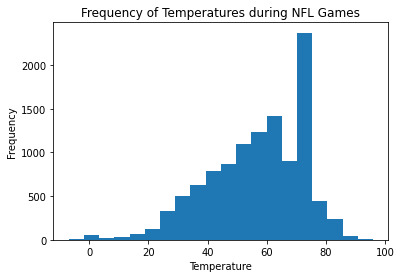

In [ ]:
#Plotting the frequency of temperatures
plt.hist(data.temperature, bins=20)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Frequency of Temperatures during NFL Games')

Temperature is distributed fairly normally around 60 degrees, but there is a huge spike in the low 70s due to indoor stadiums being kept at 72. Weather under freezing seems to be less common, but still very possible.

Text(0.5, 1.0, 'Temperature of NFL Games by Year')

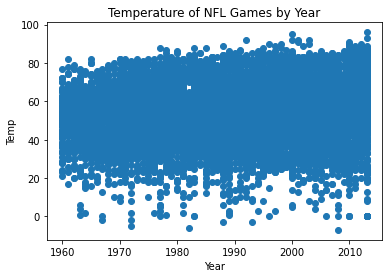

In [ ]:
#Make a scatterplot of temperature by year
plt.scatter(data.year, data.temperature)
plt.xlabel('Year')
plt.ylabel('Temp')
plt.title('Temperature of NFL Games by Year')

From the graph above, it seems that temperatures between 25 and 80 degrees are the most common, with a fair amount of colder games and very few games above the mid 80s.

Text(0.5, 1.0, 'Frequency of Wind Chill Temperatures during NFL Games')

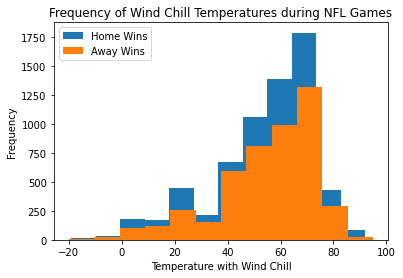

In [ ]:
#Visualizting the frequency of home team wins
data_home_win = data[data['home_win'] == 1]
data_away_win = data[data['home_win'] == 0]

#Plot frequency of home and away wins
plt.hist(data_home_win.wind_temp, bins=12, label='Home Wins')
plt.hist(data_away_win.wind_temp, bins=12, label='Away Wins')
plt.legend()
plt.xlabel('Temperature with Wind Chill')
plt.ylabel('Frequency')
plt.title('Frequency of Wind Chill Temperatures during NFL Games')

From this simple bar graph, it is clear that the home team always has a higher winning percentage than the away team, despite the temperature with wind chill.

It is significant in the graph above that there are very few NFL games played in history with a wind chill of under 0 degrees. Meaning that there are very few significantly cold games in history.

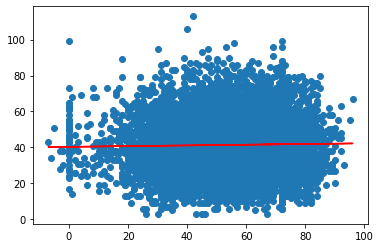

In [ ]:
#Make scatter plot of temperature vs total score
plt.scatter(data.temperature, data.total_score)

#Make regression line
line = sklearn.linear_model.LinearRegression()
        
x = np.array(data.temperature)
y = np.array(data.total_score)

line.fit(x.reshape(-1,1),y)
predicted = line.predict(x.reshape(-1,1))
        
r_value = line.score(x.reshape(-1,1),y)
        
plt.plot(x,predicted, c='r', label=r_value)
    
plt.show()

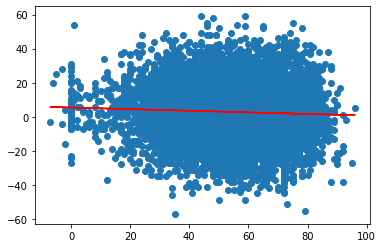

In [ ]:
#Make scatter plot of temperature vs difference in scores
plt.scatter(data.temperature, (data.home_score - data.away_score))

#Make regression line
line = sklearn.linear_model.LinearRegression() 

x = np.array(data.temperature)
y = np.array((data.home_score - data.away_score))

line.fit(x.reshape(-1,1),y)
predicted = line.predict(x.reshape(-1,1))
        
r_value = line.score(x.reshape(-1,1),y)
        
        
plt.plot(x,predicted, c='r', label=r_value)
    
plt.show()

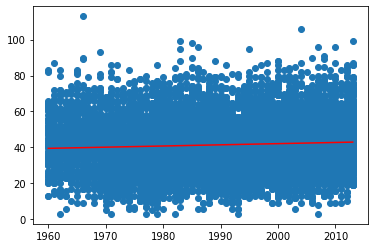

In [ ]:
#Make scatter plot of year vs total score
plt.scatter(data.year, data.total_score)

#Make regression line
line = sklearn.linear_model.LinearRegression()
        
x = np.array(data.year)
y = np.array(data.total_score)

line.fit(x.reshape(-1,1),y)
predicted = line.predict(x.reshape(-1,1))
        
r_value = line.score(x.reshape(-1,1),y)
                
plt.plot(x,predicted, c='r', label=r_value)
    
plt.show()

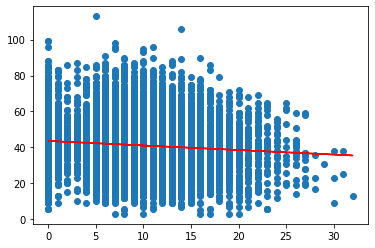

In [ ]:
#Make scatter plot of wind speed vs total score
plt.scatter(data.wind_mph, data.total_score)

#Make regression line
line = sklearn.linear_model.LinearRegression()
        
x = np.array(data.wind_mph)
y = np.array(data.total_score)

line.fit(x.reshape(-1,1),y)
predicted = line.predict(x.reshape(-1,1))
        
r_value = line.score(x.reshape(-1,1),y)
        
plt.plot(x,predicted, c='r', label=r_value)
    
plt.show()

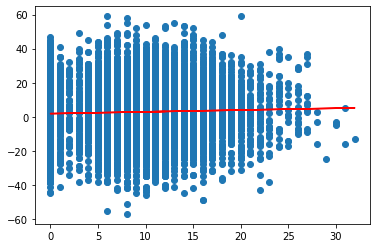

In [ ]:
#Make scatter plot of wind speed vs difference in scores
plt.scatter(data.wind_mph, (data.home_score - data.away_score))

#Make regression line
line = sklearn.linear_model.LinearRegression()
        
x = np.array(data.wind_mph)
y = np.array((data.home_score - data.away_score))

line.fit(x.reshape(-1,1),y)
predicted = line.predict(x.reshape(-1,1))
        
r_value = line.score(x.reshape(-1,1),y)
        
plt.plot(x,predicted, c='r', label=r_value)
plt.show()

# **Analysis**

While graphs are useful when looking for trends, it is hard to analyze a graph for such a large dataset. We can use summary statistics to get a better idea of what the data represents.

In [ ]:
data.describe()

home_score    away_score  ...      home_win          year
count  11192.000000  11192.000000  ...  11192.000000  11192.000000
mean      22.102752     19.347659  ...      0.580147   1989.972659
std       10.580843     10.246494  ...      0.493557     14.298750
min        0.000000      0.000000  ...      0.000000   1960.000000
25%       14.000000     13.000000  ...      0.000000   1978.000000
50%       21.000000     19.000000  ...      1.000000   1991.000000
75%       28.000000     27.000000  ...      1.000000   2002.000000
max       72.000000     62.000000  ...      1.000000   2013.000000

[8 rows x 9 columns]

In [ ]:
data_freezing = data[data['temperature'] <= 32]
data_warm = data[data['temperature'] > 32]

print((data_freezing.home_score).mean()) #Mean score for home teams when weather is below freezing
print((data_warm.home_score).mean()) #Mean score for home teams when weather is above freezing

22.618838992332968
22.05691215098745


In [ ]:
print((data_freezing.away_score).mean()) #Mean score for away teams when weather is below freezing
print((data_warm.away_score).mean()) #Mean score for away teams when weather is above freezing

18.31106243154436
19.439731491390212


In [ ]:
print((data_freezing.total_score).mean()) #Mean total added score when weather is below freezing
print((data_warm.total_score).mean()) #Mean total added score when weather is above freezing

40.929901423877325
41.49664364237766


In [ ]:
print((data_freezing.home_win).mean()) #Mean win % for home teams when weather is below freezing
print((data_warm.home_win).mean()) #Mean win % for home teams when weather is above freezing

0.6363636363636364
0.5751532250218893


After analyzing the data presented, we discover a few things


*   On average, home teams score more than away teams in both the colder and warmer weather (above and below freezing), but the margin is larger in colder weather
*   The mean total combined score is lower when the temperature is below freezing
*   The win percentage for home teams is noticeably higher when the weather is below freezing (63.6% compared to 57.5%)
*   On average, away teams score more in warmer weather than colder weather. Surprisingly, home teams score more in colder weather than warmer weather on average.





# **Machine Learning - Regression Algorithms**

In this section, we use Machine Learning to predict certain outcomes. In order to do this, we must train a regression algorithm using the data that we have available. We use all of the data available in order to get the most accurate prediction. To test this prediction and see the results, we simulate a dataset to use the algorithm on, predicting the likelihood of the outcome. We look at temperature and wind speed in order to predict the likelihood of a few different things. Apart from just win probabilities, we also look at over/under betting lines.

To do this, we convert the needed columns of our "data" dataframe to a numpy array and reshape it to the proper format. Then, we create our logistic regression model and fit it to the array data. That completes the model creation, so now we generate testing data and input those values into the regression equation, producing an output of probabilities. We then graph and label those probabilities, and print out the model incercept and coefficient, seen below each snippet of code.

We look at the impact of temperature and wind speed on
*   Win Probability
*   Over/Under Betting lines



intercept(theta_0): 0.6508131482943434 
Coefficient(theta_1):  -0.005763782353005128


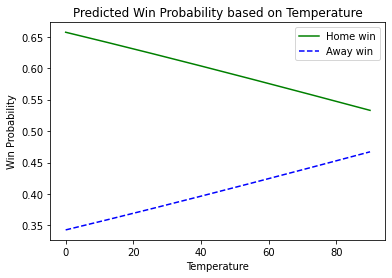

In [ ]:
# Convert columns to arrays
a = (data.temperature).to_numpy()
b = (data.home_win).to_numpy()

a = a.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(a,b)

#Print out model variables (Intercept and coefficient for green line)
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,90,1000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Home win")
plt.plot(X_test,y_prob[:,0],"b--",label = "Away win")
plt.xlabel('Temperature')
plt.ylabel('Win Probability')
plt.title('Predicted Win Probability based on Temperature')
plt.legend()
plt.show()

intercept(theta_0): 0.2179061918593528 
Coefficient(theta_1):  0.012419282567532155


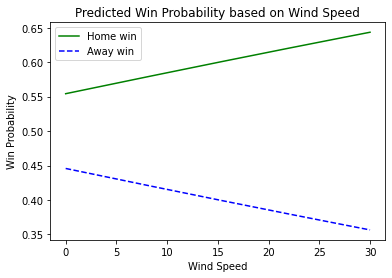

In [ ]:
#Convert columns to arrays
e = (data.wind_mph).to_numpy()
f = (data.home_win).to_numpy()

e = e.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(e,f)

#Print out model variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,30,1000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Home win")
plt.plot(X_test,y_prob[:,0],"b--",label = "Away win")
plt.xlabel('Wind Speed')
plt.ylabel('Win Probability')
plt.title('Predicted Win Probability based on Wind Speed')
plt.legend()
plt.show()

intercept(theta_0): 0.11278331490520681 
Coefficient(theta_1):  -0.005002349315483684


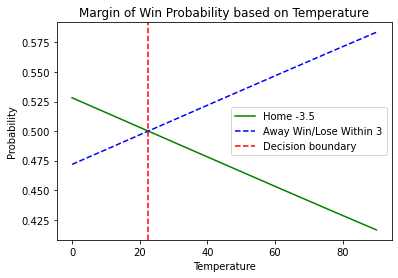

In [ ]:
#Convert columns to array
c = (data.temperature).to_numpy()
d1 = ((data.home_score - data.away_score)>3).astype(np.int)
d = (d1).to_numpy()

c = c.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(c,d)

#Print out model variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,90,5000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Home -3.5")
plt.plot(X_test,y_prob[:,0],"b--",label = "Away Win/Lose Within 3")
plt.axvline(x=22.5,color='r',linestyle="--",label="Decision boundary")
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Margin of Win Probability based on Temperature')
plt.legend()
plt.show()

intercept(theta_0): -0.2575522059522499 
Coefficient(theta_1):  0.01019412506293671


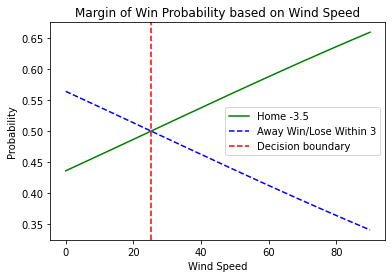

In [ ]:
#Convert columns to array
c2 = (data.wind_mph).to_numpy()
d3 = ((data.home_score - data.away_score)>3).astype(np.int)
d2 = (d3).to_numpy()

c2 = c2.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(c2,d2)

#Print out model variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,90,5000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Home -3.5")
plt.plot(X_test,y_prob[:,0],"b--",label = "Away Win/Lose Within 3")
plt.axvline(x=25.1,color='r',linestyle="--",label="Decision boundary")
plt.xlabel('Wind Speed')
plt.ylabel('Probability')
plt.title('Margin of Win Probability based on Wind Speed')
plt.legend()
plt.show()

intercept(theta_0): -0.057702332641993793 
Coefficient(theta_1):  -0.0052420482492602566


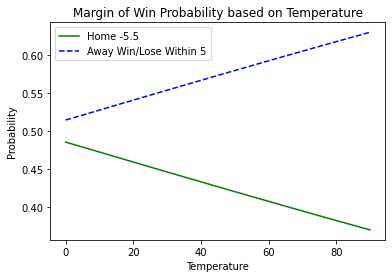

In [ ]:
#Convert columns to array
g = (data.temperature).to_numpy()
h1 = ((data.home_score - data.away_score)>5).astype(np.int)
h = (h1).to_numpy()

g = g.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(g,h)

#Print out model variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,90,5000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Home -5.5")
plt.plot(X_test,y_prob[:,0],"b--",label = "Away Win/Lose Within 5")
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Margin of Win Probability based on Temperature')
plt.legend()
plt.show()

intercept(theta_0): -0.4653693118346982 
Coefficient(theta_1):  0.012982937262395756


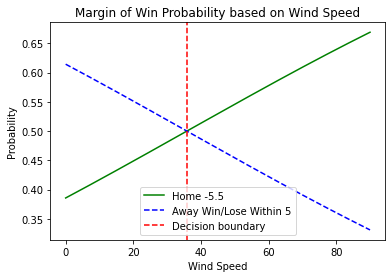

In [ ]:
#Convert columns to array
g2 = (data.wind_mph).to_numpy()
h3 = ((data.home_score - data.away_score)>5).astype(np.int)
h2 = (h3).to_numpy()

g2 = g2.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(g2,h2)

#Print out model variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,90,5000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Home -5.5")
plt.plot(X_test,y_prob[:,0],"b--",label = "Away Win/Lose Within 5")
plt.axvline(x=35.9,color='r',linestyle="--",label="Decision boundary")
plt.xlabel('Wind Speed')
plt.ylabel('Probability')
plt.title('Margin of Win Probability based on Wind Speed')
plt.legend()
plt.show()

After looking at at logistic regressions for different scenarios, it is clear that on average, home teams will always be favored despite the weather conditions. However, weather still has a large impact on the win probabilities. For example, while no conditions will end up favoring the away team (on average), lower wind and higher temperature make it more likely for the away team to win.

Looking at the betting odds, it seems that the only time to take the home team -3.5 is when the weather is below 22.5 degrees. The narrow 3 point win margin is the most common one in all of football, which is why we are able to see a clear decision boundary for margins of win strictly higher than that value. On the other hand, taking the home team at -5.5 is far more unlikely, and there is no segment where the home team should be taken. However, it is much more likely at lower temperatures, but never favored. 

The home team is also favored at -3.5 when wind is above 25.1 mph, and favored at -5.5 when wind is above 35.9 mph. While 25 mph hour winds are realistic, 36 mph winds are extremely improbable for an NFL game. It seems that only extreme winds should affect the outcome of the game enough to influence betting odds.

intercept(theta_0): -0.09122694319304342 
Coefficient(theta_1):  0.0022084882213521304


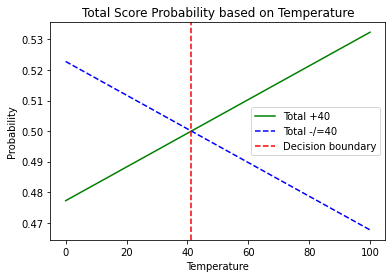

In [ ]:
#Convert columns to array
i = (data.temperature).to_numpy()
j1 = ((data.total_score)>40).astype(np.int)
j = (j1).to_numpy()

i = i.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(i,j)

#Print out mode variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,100,5000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Total +40")
plt.plot(X_test,y_prob[:,0],"b--",label = "Total -/=40")
plt.axvline(x=41.25,color='r',linestyle="--",label="Decision boundary")
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Total Score Probability based on Temperature')
plt.legend()
plt.show()

intercept(theta_0): 0.30187716058367153 
Coefficient(theta_1):  -0.03141332667783461


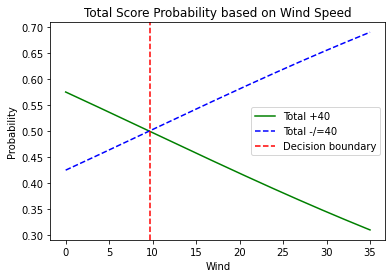

In [ ]:
#Convert columns to arrays
k = (data.wind_mph).to_numpy()
l1 = ((data.total_score)>40).astype(np.int)
l = (l1).to_numpy()

k = k.reshape(-1,1)

#Fit regression model to data
log_reg = LogisticRegression()
model = log_reg.fit(k,l)

#Print out model variables
print("intercept(theta_0):", model.intercept_[0],"\nCoefficient(theta_1): ",model.coef_[0][0])

#Create testing data
X_test = np.linspace(0,35,5000).reshape(-1,1)

#Find probabilities off of data, graph
y_prob = log_reg.predict_proba(X_test)
plt.plot(X_test,y_prob[:,1],"g-",label="Total +40")
plt.plot(X_test,y_prob[:,0],"b--",label = "Total -/=40")
plt.axvline(x=9.75,color='r',linestyle="--",label="Decision boundary")
plt.xlabel('Wind')
plt.ylabel('Probability')
plt.title('Total Score Probability based on Wind Speed')
plt.legend()
plt.show()

The logistic regression above looks at the over/under for the total score. The average total score is roughly 40 points, and it seems that the over is more likely above 42.5 degrees. On the other hand, it seems that it is less likely when the wind is 10mph or above. Therefore, it is best to take the over on 40 when the wind is below 10mph and the temperature is above 42.5 degrees.

*Note - These models are not actually linear, but are only linear because of the large sample size and small range. When expanding the range, they lose their linearity.

*Note - We choose not to do regressions on wind chill, because it only impacts colder weather and would skew the data a bit. The same information can be gathered from temperature and wind speed separately without affecting the validity of the data.

# **Conclusions**

After careful analysis, it is very clear that weather regularly impacts the outcome of NFL games.

**Win Probability**
Lower temperatures and higher wind speeds both favor home teams, and higher temperatures and lower wind speeds will help away teams but not enough to favor them. The probability of the home team winning is about 2/3 when the temperature is 0 degrees, and it nears 1/2 as the temperature exceeds 100 degrees. The probability of the home team winning is around 56% with no wind and gets closer to 65% as wind speeds near 30 mph, which is possible but not as plausible. 

**Point Spreads**
There was a clear trend between temperature and certain point spreads. Based on the decision boundaries, the home team would be favored at -3.5 when the temperature is below 22.5 degrees and/or the wind speed is above 25.1 mph. Even if these values were acheived, which is uncommon, the likelihood isn't far from 50%.

At -5.5, the home team would never realistically be favored based on temperature. The probability is higher when the temperature is closer to 0, but it would take extremely low temperatures for the probability to eclipse 50%. Wind would favor the home team at -5.5 with speeds above 35.9, which are highly unlikely. It seems that the home team at -5.5 will never be favored based on weather conditions.

**Totals (over/unders)**
It seems that weather does have an impact on the decision on taking over/under at 40. Taking the under is favored when temperatures are below 41.25 degrees and/or wind speeds are above 9.75 mph. Otherwise, it is smarter to take the over. Wind speeds have a much greater impact on this, likely because of the strong impact on throwing the ball and kicking field goals.

**Overall**
Weather, specifically wind and temperature, **does** have an impact on NFL games. While it may not influence games enough for someone to confidently bet based on weather, weather impacts games enough for the NFL and teams to take it into account when picking stadium designs and super bowl locations. 


**What's Next?**

Now that we've seen that weather, especially cold weather, impacts games, there are a few more valuable things that could be looked at.

1. Humidity

We did not look much at humidity since we focused more on cold weather factors. It would be interesting to see how this affects home teams, since many regions with NFL teams (such as Texas) are far dryer than others (Florida, California).

2. Geography/Franchises

We did not look at any specific locations or teams when doing this research. It would be interesting to see how the results vary between teams.

3. Multiple Variables

While we did look at multiple variables separately, we did not look at any in the same graph. Wind chill proved to be unreliable, so looking at wind and temperature together might yield interesting results. It would also help to make predictions more scenario-specific.

4. Betting

We proved that weather impacts NFL games, but we did not specifically prove how it impacts different scenarios for betting. This project was to determine relevance, but another could be done to see how weather specifically impacts betting on NFL games. Further analysis and lots of machine learning would need to be done to have accurate predictions.

5. Other factors

We completed this analysis based on the assumption that the matchup between home and away teams was even. Different skill levels, away teams' normal weather conditions, length of travel, and many more things could impact the outcome of games as well. The results of our data prove that more research is warranted. There is lots of information online, at websites such as this one: https://model284.com/the-impact-of-situational-factors-on-nfl-games/.


